# SECCIÓN 1: ANÁLISIS DE SENTIMIENTOS

In [21]:
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Inicializar el analizador de sentimientos de VADER
analyzer = SentimentIntensityAnalyzer()

# Diccionario de emociones para clasificar
sentimientos = {
    'alegría': 0, 
    'enojo': 1, 
    'tristeza': 2, 
    'satisfacción': 3, 
    'insatisfacción': 4
}

# Palabras clave y frases específicas del dialecto ecuatoriano para emociones negativas
palabras_clave_negativas = [
    'sinvergüenza', 'charlatán', 'mañoso', 'corrupto', 'inútil', 'maldito', 'ladrón', 'hipócrita',
    'vergonzoso', 'mentiroso', 'desgraciado', 'canalla', 'ratero'
]

# Función para clasificar el sentimiento basado en el análisis de VADER y palabras clave específicas
def clasificar_sentimiento(comentario):
    analisis = TextBlob(comentario)
    vader_result = analyzer.polarity_scores(comentario)
    
    # Clasificación basada en el análisis de VADER
    if vader_result['compound'] >= 0.5:
        return 'alegría'
    elif vader_result['compound'] >= 0.1:
        return 'satisfacción'
    elif vader_result['compound'] <= -0.5:
        return 'enojo'
    elif vader_result['compound'] <= -0.1:
        return 'tristeza'
    
    # Clasificación adicional basada en palabras clave específicas
    for palabra in palabras_clave_negativas:
        if palabra in comentario:
            return 'enojo'
    
    return 'insatisfacción'

def analizar_sentimientos(df):
    emociones = {'alegría': [], 'enojo': [], 'tristeza': [], 'satisfacción': [], 'insatisfacción': []}
    
    aspectos = []
    sentim = []

    for index, row in df.iterrows():
        comentario = row['comment_limpio']
        sentimiento = clasificar_sentimiento(comentario)
        emociones[sentimiento].append(comentario)
        aspectos.append('positivo' if sentimiento in ['alegría', 'satisfacción'] else 'negativo' if sentimiento in ['enojo', 'tristeza'] else 'neutral')
        sentim.append(sentimiento)
    
    df['aspecto'] = aspectos
    df['sentimiento'] = sentim
    df['sentimiento_label'] = df['sentimiento'].map(sentimientos)
    
    return df, emociones


In [22]:
import pandas as pd

def comparar_aspectos(df):
    # Implementación de la función para comparar aspectos
    pass  # Reemplaza con la lógica real


In [23]:
import pandas as pd

def identificar_temas(df):
    # Aquí va la lógica para identificar temas
    # Por ahora, simplemente devolvamos una lista vacía como ejemplo
    temas = []
    return temas


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

def generar_matriz_confusion(y_true, y_pred, labels, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')

def generar_visualizaciones(df, y_true, y_pred, labels):
    # Mapeo de los sentimientos para etiquetas comprensibles
    sentimiento_map = {0: 'alegría', 1: 'enojo', 2: 'tristeza', 3: 'satisfacción', 4: 'insatisfacción'}
    df['sentimiento_label'] = df['sentimiento'].map(sentimiento_map)

    # Crear figura con subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Análisis de Sentimientos y Aspectos', fontsize=16)

    # Conteo de sentimientos
    sns.countplot(x='sentimiento_label', data=df, palette='viridis', ax=axes[0, 0])
    axes[0, 0].set_title('Distribución de Sentimientos')
    axes[0, 0].set_xlabel('Sentimientos')
    axes[0, 0].set_ylabel('Conteo')

    # Evolución temporal de los sentimientos
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.resample('M', on='timestamp').size().plot(ax=axes[0, 1])
    axes[0, 1].set_title('Número de Comentarios por Mes')
    axes[0, 1].set_xlabel('Fecha')
    axes[0, 1].set_ylabel('Número de Comentarios')

    # Análisis de temas y aspectos
    if 'aspecto' in df.columns:
        sns.countplot(x='aspecto', data=df, palette='coolwarm', ax=axes[1, 0])
        axes[1, 0].set_title('Distribución de Aspectos')
        axes[1, 0].set_xlabel('Aspectos')
        axes[1, 0].set_ylabel('Conteo')

    # Matriz de confusión
    generar_matriz_confusion(y_true, y_pred, labels, axes[1, 1])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# SECCIÓN 2: LIMPIEZA DE DATOS

In [25]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import os
import tkinter as tk
from tkinter import ttk
from sklearn.feature_extraction.text import TfidfVectorizer

# Descargar y cargar manualmente los recursos necesarios de NLTK si no se han descargado previamente
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

def limpiar_caracteres(texto):
    if isinstance(texto, str):
        texto_limpio = re.sub(r'[^a-zA-Z\s]', '', texto, flags=re.I|re.A)
        return texto_limpio.lower()
    else:
        return ''

def tokenizar_texto(texto):
    tokens = word_tokenize(texto)
    return tokens

def eliminar_stopwords(tokens):
    stopwords_esp = set(stopwords.words('spanish'))
    tokens_filtrados = [token for token in tokens if token.lower() not in stopwords_esp]
    return tokens_filtrados

def lematizar_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    tokens_lemmatizados = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens_lemmatizados

def limpiar_datos_fila(fila):
    fila['comment_limpio'] = limpiar_caracteres(fila['comment'])
    tokens = tokenizar_texto(fila['comment_limpio'])
    tokens = eliminar_stopwords(tokens)
    tokens = lematizar_tokens(tokens)
    fila['tokens'] = tokens
    return fila

def cargar_csv(file_name):
    csv_path = os.path.join('datasets', datos_combinados_1)
    df = pd.read_csv(csv_path, delimiter=',')
    df.rename(columns={'comment': 'comment'}, inplace=True)  # Asegurarse de que la columna se llama 'comment'
    return df

def limpiar_datos(df):
    filas_limpias = []
    for _, fila in df.iterrows():
        filas_limpias.append(limpiar_datos_fila(fila))
    df_limpio = pd.DataFrame(filas_limpias)
    return df_limpio

def vectorizar_texto(df):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['comment_limpio'])
    return tfidf_matrix, tfidf_vectorizer.get_feature_names_out()

def mostrar_resultados(df, tfidf_matrix, feature_names):
    root = tk.Tk()
    root.title("Resultados de Limpieza de Datos")

    tree = ttk.Treeview(root)
    tree["columns"] = ("comment", "comment_limpio", "tokens", "tfidf")

    tree.column("#0", width=0, stretch=tk.NO)
    tree.column("comment", anchor=tk.W, width=200)
    tree.column("comment_limpio", anchor=tk.W, width=200)
    tree.column("tokens", anchor=tk.W, width=200)
    tree.column("tfidf", anchor=tk.W, width=200)

    tree.heading("#0", text="", anchor=tk.W)
    tree.heading("comment", text="Comentarios Originales", anchor=tk.W)
    tree.heading("comment_limpio", text="Comentarios Limpios", anchor=tk.W)
    tree.heading("tokens", text="Tokens", anchor=tk.W)
    tree.heading("tfidf", text="TF-IDF", anchor=tk.W)

    for index, row in df.iterrows():
        tfidf_vector = tfidf_matrix[index].toarray().flatten()
        tfidf_scores = {feature_names[i]: tfidf_vector[i] for i in range(len(feature_names)) if tfidf_vector[i] > 0}
        tree.insert("", index, text="", values=(row["comment"], row["comment_limpio"], row["tokens"], str(tfidf_scores)))

    tree.pack(expand=True, fill='both')
    
    root.mainloop()


In [26]:
from sklearn.model_selection import train_test_split

def dividir_datos(df, test_size=0.2, validation_size=0.1):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    train_df, val_df = train_test_split(train_df, test_size=validation_size/(1-test_size), random_state=42)
    return train_df, val_df, test_df



# SECCIÓN 3: MODELO RNN

In [27]:
import tensorflow as tf

def definir_modelo_rnn(vocab_size, max_len):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
        tf.keras.layers.LSTM(64, return_sequences=True),  # Reducir unidades LSTM
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation='relu'),  # Reducir unidades Dense
        tf.keras.layers.Dense(5, activation='softmax')  # 5 clases para los sentimientos
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model


In [28]:
import tensorflow as tf
import pickle
from tqdm import tqdm

def entrenar_y_guardar_modelo_rnn(model, X_train, y_train, X_val, y_val, tokenizer, epochs=500, batch_size=128):
    # Implementar Early Stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Entrenar el modelo con una barra de progreso
    with tqdm(total=epochs, desc="Training Model") as pbar:
        for epoch in range(epochs):
            history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)
            pbar.update(1)
            pbar.set_postfix(loss=history.history['loss'][-1], accuracy=history.history['accuracy'][-1], val_loss=history.history['val_loss'][-1], val_accuracy=history.history['val_accuracy'][-1])
            if early_stopping.stopped_epoch > 0:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Guardar el modelo y el tokenizer
    print("Guardando el modelo y el tokenizer...")
    model.save('modelo_rnn.keras')
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle)
    print("Modelo guardado en modelo_rnn.keras.")
    print("Tokenizer guardado en tokenizer.pickle.")


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf

def evaluar_modelo_rnn(model, test_df, tokenizer):
    # Convertir los datos de prueba en secuencias
    X_test = tokenizer.texts_to_sequences(test_df['comment_limpio'].values)
    X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=50)  # Usar la misma longitud que en el entrenamiento

    # Obtener las etiquetas de los datos de prueba
    y_test = test_df['sentimiento'].astype('float32')

    # Realizar predicciones
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generar la matriz de confusión y el informe de clasificación
    cm = confusion_matrix(y_test, y_pred_classes)
    cr = classification_report(y_test, y_pred_classes, target_names=['alegría', 'enojo', 'tristeza', 'satisfacción', 'insatisfacción'])

    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(cr)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['alegría', 'enojo', 'tristeza', 'satisfacción', 'insatisfacción'], yticklabels=['alegría', 'enojo', 'tristeza', 'satisfacción', 'insatisfacción'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return cr, cm


# SECCIÓN 4: EJECUCIÓN PRINCIPAL

Cargando datos...
Datos cargados: 2878 registros, 3 columnas
           username                 timestamp  \
0      @MarcoGilerM  2023-09-11T13:37:46.000Z   
1  @JoseAnt40060050  2023-09-01T22:39:33.000Z   
2  @MariaMa99904828  2023-05-31T00:22:19.000Z   
3      @patsurfer71  2023-03-30T12:27:34.000Z   
4  @Joselui48173725  2023-02-01T13:43:37.000Z   
5    @juancasaenz76  2023-01-31T18:21:38.000Z   
6     @radialvision  2023-01-30T20:57:29.000Z   
7    @mmendozabelen  2023-01-30T19:11:53.000Z   
8         @HRZManta  2022-07-08T20:08:41.000Z   
9         @HRZManta  2022-06-13T16:33:54.000Z   

                                             comment  
0  eso no es todo al realizarse la transferencia ...  
1  nunca entregaste un hospital para la zona sur ...  
2  a mas de adefesio sinverguenza charlatan cuand...  
3  jipijapa necesita un hospital general que pued...  
4  hay jente que tienen caca en el serebropor k v...  
5  x ej los dos funcionarios atacados a bala en p...  
6  noticias  s

C:\Users\Erick Carreño\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Erick Carreño\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Definiendo el modelo...
Entrenando el modelo...


Training Model: 100%|███| 100/100 [03:48<00:00,  2.29s/it, accuracy=1, loss=0.000228, val_accuracy=0.74, val_loss=2.09]


Guardando el modelo y el tokenizer...
Modelo guardado en modelo_rnn.keras.
Tokenizer guardado en tokenizer.pickle.
Evaluando el modelo...
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Confusion Matrix:
[[  1   1   1   1   3]
 [  0  29   7   3   2]
 [  0   8  64  24   6]
 [  1   0  12   6  18]
 [  4   0   6  23 356]]

Classification Report:
                precision    recall  f1-score   support

       alegría       0.17      0.14      0.15         7
         enojo       0.76      0.71      0.73        41
      tristeza       0.71      0.63      0.67       102
  satisfacción       0.11      0.16      0.13        37
insatisfacción       0.92      0.92      0.92       389

      accuracy                           0.79       576
     macro avg       0.53      0.51      0.52       576
  weighted avg       0.81      0.79      0.80       576



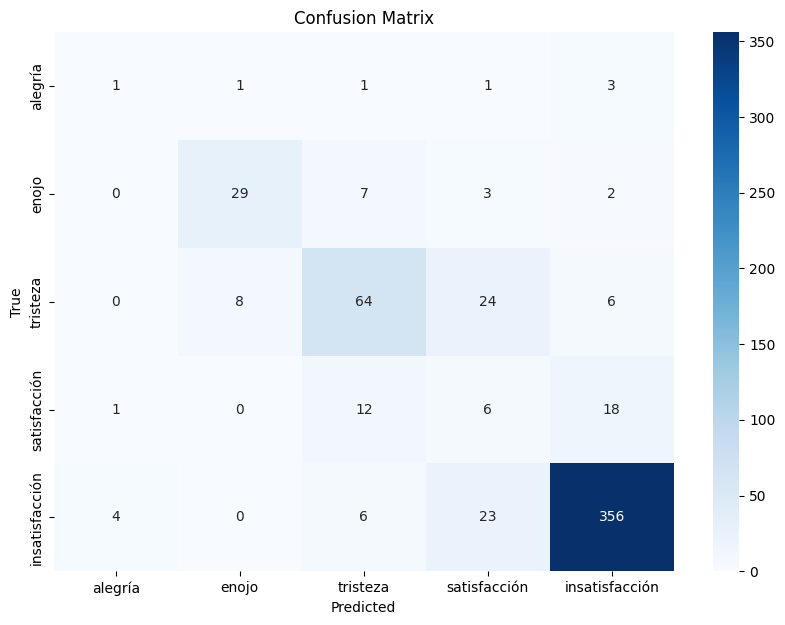

Generando visualizaciones...
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


C:\Users\Erick Carreño\AppData\Local\Temp\ipykernel_29588\1778997782.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentimiento_label', data=df, palette='viridis', ax=axes[0, 0])
C:\Users\Erick Carreño\AppData\Local\Temp\ipykernel_29588\1778997782.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample('M', on='timestamp').size().plot(ax=axes[0, 1])
C:\Users\Erick Carreño\AppData\Local\Temp\ipykernel_29588\1778997782.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='aspecto', data=df, palette='coolwarm', ax=axes[1, 0])


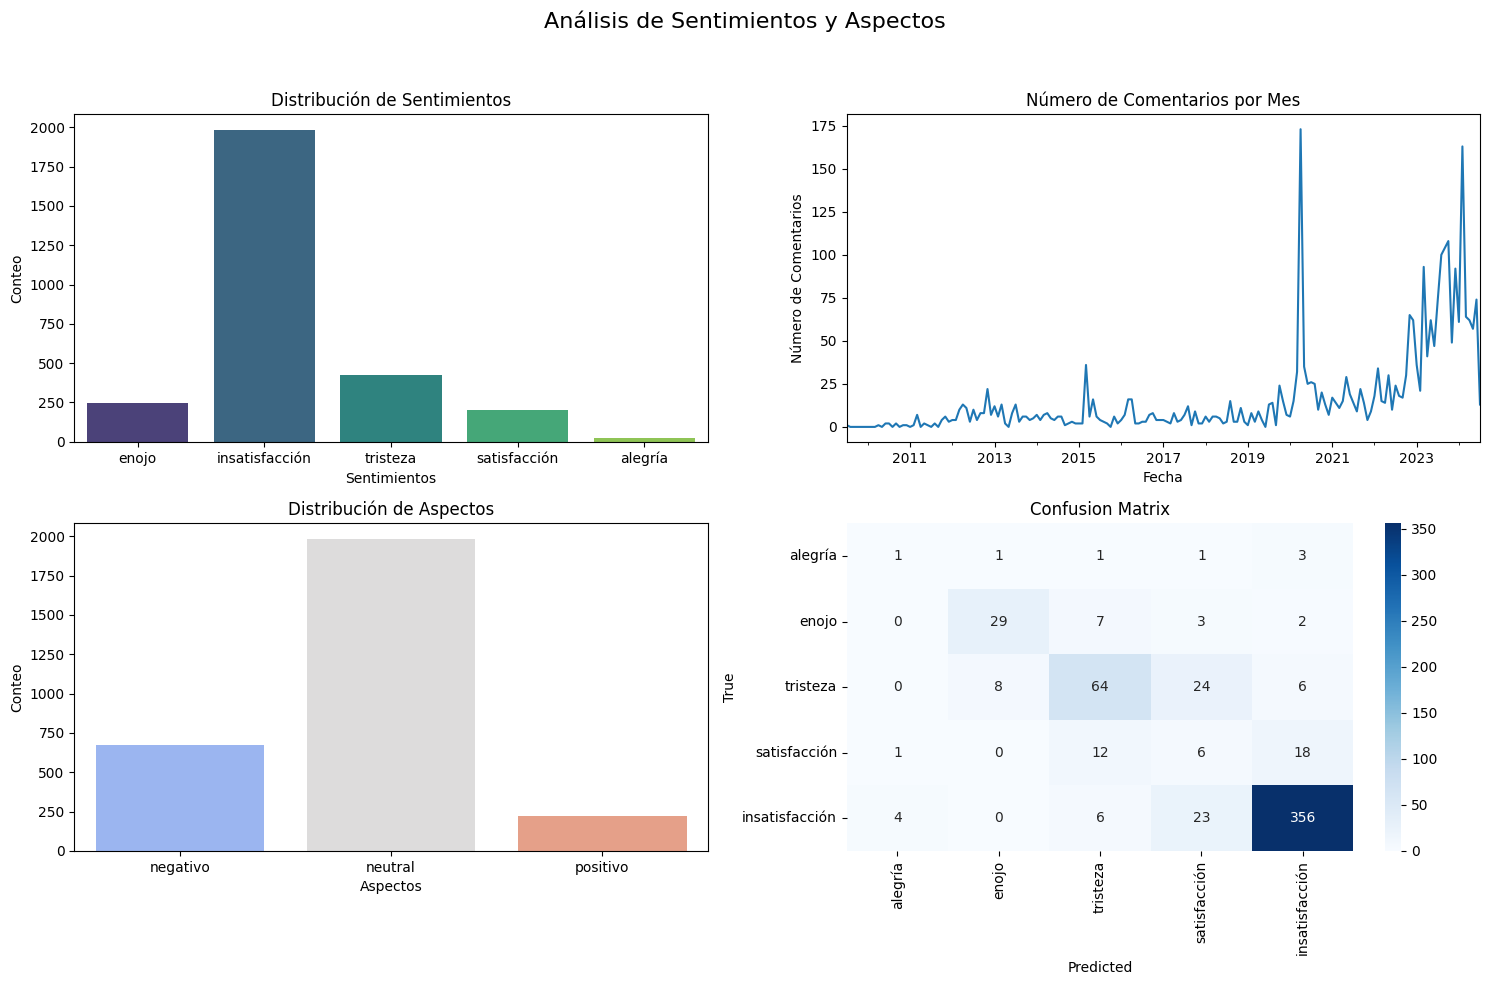

Visualizaciones generadas.


In [30]:
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pickle

# Cargar datos
print("Cargando datos...")
df = pd.read_csv('datasets/datos_combinados_1.csv')
print(f"Datos cargados: {len(df)} registros, {len(df.columns)} columnas")
print(df.head(10))

# Limpiar datos
print("Limpiando datos...")
df = limpiar_datos(df)
print(f"Columnas disponibles después de limpiar los datos: {df.columns}")
print(df.head(10))

# Vectorizar texto y mostrar resultados
print("Vectorizando texto...")
tfidf_matrix, feature_names = vectorizar_texto(df)
print("Mostrando resultados de limpieza de datos...")
mostrar_resultados(df, tfidf_matrix, feature_names)

# Análisis de sentimientos
print("Análisis de sentimientos...")
df, emociones = analizar_sentimientos(df)
print(f"Columnas disponibles después del análisis de sentimientos: {df.columns}")
print(f"Emociones detectadas: { {key: len(value) for key, value in emociones.items()} }")
print(df.head(10))

# Verificar contenido de 'sentimiento_label'
print("Contenido de 'sentimiento_label':")
print(df['sentimiento_label'].unique())

# Corregir mapeo: asegurar que 'sentimiento_label' contenga cadenas
sentimiento_map = {'alegría': 0, 'enojo': 1, 'tristeza': 2, 'satisfacción': 3, 'insatisfacción': 4}
label_to_text = {v: k for k, v in sentimiento_map.items()}
df['sentimiento_label'] = df['sentimiento_label'].map(label_to_text)

# Convertir las etiquetas de sentimiento a valores numéricos
df['sentimiento'] = df['sentimiento_label'].map(sentimiento_map)

# Verificar mapeo
print("Verificación del mapeo de 'sentimiento_label' a 'sentimiento':")
print(df[['sentimiento_label', 'sentimiento']].drop_duplicates())

# Verificar valores NaN antes de eliminar
print(f"Valores NaN en 'sentimiento': {df['sentimiento'].isna().sum()}")

# Manejar valores NaN
df = df.dropna(subset=['sentimiento', 'comment_limpio'])

# Verificar DataFrame después de eliminar valores NaN
print(f"Datos después de eliminar NaN en 'sentimiento': {len(df)} registros")
print(df.head(10))

# Dividir datos en entrenamiento, validación y prueba
print("Dividiendo datos en entrenamiento, validación y prueba...")
train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42), [int(.7*len(df)), int(.8*len(df))])
print(f"Datos de entrenamiento: {len(train_df)} registros")
print(f"Datos de validación: {len(val_df)} registros")
print(f"Datos de prueba: {len(test_df)} registros")
print(train_df.head(10))

# Verificar datos de entrenamiento
if len(train_df) == 0:
    raise ValueError("Datos de entrenamiento están vacíos.")

# Tokenizar los datos
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000)  # Reducir el vocabulario a 5000 palabras
tokenizer.fit_on_texts(train_df['comment_limpio'].values)
X_train = tokenizer.texts_to_sequences(train_df['comment_limpio'].values)
X_val = tokenizer.texts_to_sequences(val_df['comment_limpio'].values)
X_test = tokenizer.texts_to_sequences(test_df['comment_limpio'].values)  # Tokenizar datos de prueba

# Padding
max_len = 50  # Reducir el maxlen a 50
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)  # Padding de datos de prueba

# Convertir etiquetas a numpy arrays
y_train = train_df['sentimiento'].values
y_val = val_df['sentimiento'].values
y_test = test_df['sentimiento'].values  # Etiquetas de prueba

# Definir el modelo con una red más simple
print("Definiendo el modelo...")
model = definir_modelo_rnn(vocab_size=5000, max_len=max_len)

# Entrenar el modelo, guardar el modelo y el tokenizer
print("Entrenando el modelo...")
entrenar_y_guardar_modelo_rnn(model, X_train, y_train, X_val, y_val, tokenizer, epochs=100, batch_size=256)

# Evaluar el modelo
print("Evaluando el modelo...")
cr, cm = evaluar_modelo_rnn(model, test_df, tokenizer)

# Generar visualizaciones
print("Generando visualizaciones...")
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
generar_visualizaciones(df, y_test, y_pred_classes, ['alegría', 'enojo', 'tristeza', 'satisfacción', 'insatisfacción'])
print("Visualizaciones generadas.")
